In [9]:
import torch 
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('../..'))

from pv_plot.plotting import plot_gp_ax, plot_train_test_split
from data import PVWeatherGenerator, SystemLoader
from models import ApproximateGPBaseModel
from likelihoods.beta import BetaLikelihood_MeanParametrization
from kernels import Kernel

## Weather Data

In [4]:
DAY_INIT = 0 # start of data is 01-01-2018
N_DAYS = 365 # data until 01-01-2019
DAY_MIN = 8 # starting hour of all our data (per day)
DAY_MAX = 16 # ending hour of all our data (per day)
MINUTE_INTERVAL = 5 # the minute interval of our data
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 7
N_SYSTEMS = 6
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25
interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)

In [5]:
generator = PVWeatherGenerator(
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    day_init=DAY_INIT,
    n_systems=N_SYSTEMS,
    n_days=N_DAYS,
    minute_interval=MINUTE_INTERVAL,
)
loader = SystemLoader(generator.df, train_interval=interval)

==> Loading data
==> Loaded data in: 0 m : 17 sec



In [7]:
jitter = 1e-6
gp_config = {
        'type' : 'stochastic', # SVI
        'name' : 'cholesky', # type of posterior covariance approximation
        'jitter' : jitter, # jitter for numerical stability
    }

Iter 10/100 - Loss: 6.605
Iter 20/100 - Loss: 2.548
Iter 30/100 - Loss: 1.582
Iter 40/100 - Loss: 0.697
Iter 50/100 - Loss: -0.006
Iter 60/100 - Loss: -0.557
Iter 70/100 - Loss: -0.828
Iter 80/100 - Loss: -0.822
Iter 90/100 - Loss: -0.928
Iter 100/100 - Loss: -0.985
Iter 10/100 - Loss: 6.170
Iter 20/100 - Loss: 2.358
Iter 30/100 - Loss: 1.365
Iter 40/100 - Loss: 0.449
Iter 50/100 - Loss: -0.214
Iter 60/100 - Loss: -0.680
Iter 70/100 - Loss: -0.844
Iter 80/100 - Loss: -0.922
Iter 90/100 - Loss: -1.021
Iter 100/100 - Loss: -1.014
Iter 10/100 - Loss: 5.993
Iter 20/100 - Loss: 2.559
Iter 30/100 - Loss: 1.517
Iter 40/100 - Loss: 0.598
Iter 50/100 - Loss: -0.022
Iter 60/100 - Loss: -0.502
Iter 70/100 - Loss: -0.790
Iter 80/100 - Loss: -0.685
Iter 90/100 - Loss: -0.828
Iter 100/100 - Loss: -0.904
Iter 10/100 - Loss: 6.193
Iter 20/100 - Loss: 2.687
Iter 30/100 - Loss: 1.572
Iter 40/100 - Loss: 0.747
Iter 50/100 - Loss: 0.068
Iter 60/100 - Loss: -0.484
Iter 70/100 - Loss: -0.752
Iter 80/100 - L

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

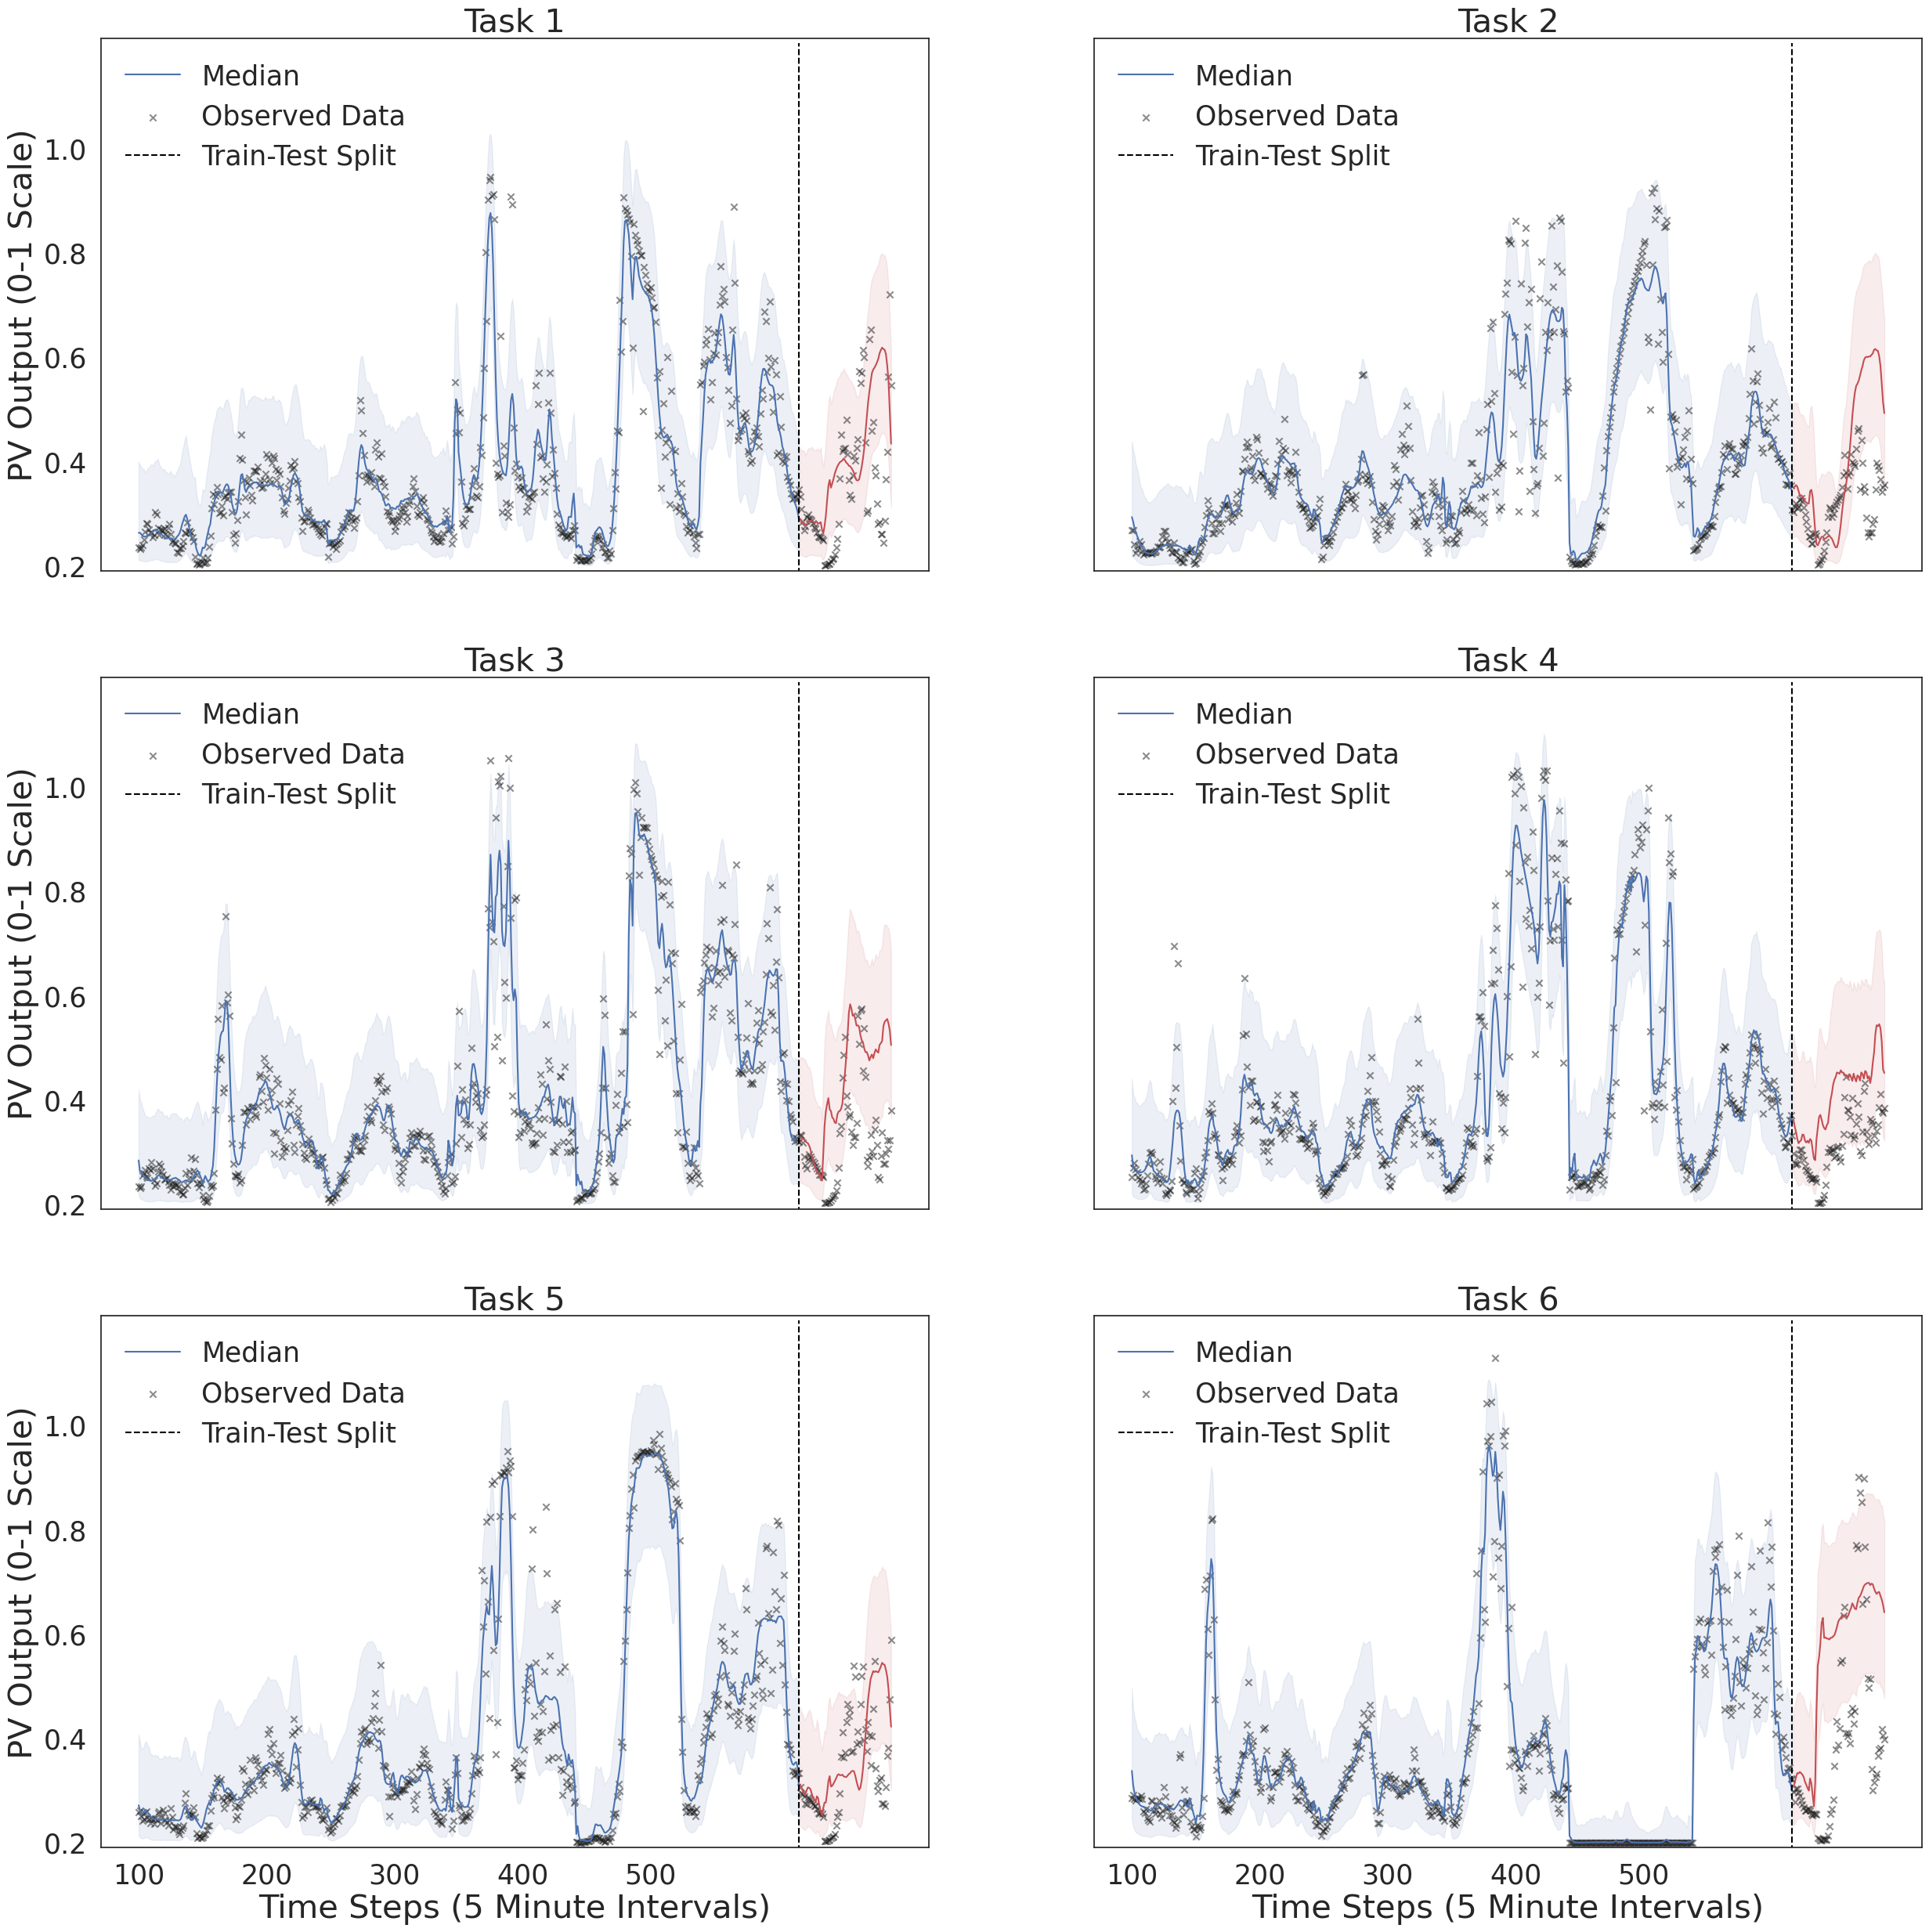

In [20]:
from kernels import get_mean_covar_weather
from models import ApproximateGPBaseModel
from likelihoods import BetaLikelihood_MeanParametrization


for X_tr, Y_tr, X_te, Y_te, T_tr, T_te in loader:
    fig, ax = plt.subplots(N_SYSTEMS // 2, 2, figsize=(30, 5 * (N_SYSTEMS)), sharex=True, sharey=True)
    ax = ax.flatten()
    plt.rcParams['font.serif'] = ['Times New Roman']
    
    for i in range(loader.n_systems):
        x_tr, y_tr, x_te, y_te = loader.train_test_split_individual(i)
        x_tr = x_tr[:,:-1]
        x_te = x_te[:,:-1]
        gp_config['num_inducing_points'] = x_tr.shape[0]
        mean, covar = get_mean_covar_weather(num_latents=1, d=x_tr.shape[-1], weather_kernel='matern', combine='product')

        model = ApproximateGPBaseModel(
            X=x_tr,
            y=y_tr,
            mean_module=mean,
            covar_module=covar,
            likelihood = BetaLikelihood_MeanParametrization(scale=30),
            config=gp_config,
        )
     
        model.fit(n_iter=100, lr=0.2, verbose=True)
        
        plot_gp_ax(model, x_tr, x_te, y_tr, y_te, pred_type='median', ax=ax[i])
        ax[i].set_title(f'Task {i+1}', fontsize=30)
        ax[i].legend(fontsize=25, loc='upper left')
        # set y label for left column
        if i % 2 == 0:
            ax[i].set_ylabel('PV Output (0-1 Scale)', fontsize=30)
            # add y ticks
            y_ticks_rounded = np.round(np.arange(0, 1.1, 0.2), 1)
            ax[i].set_yticklabels(y_ticks_rounded, fontsize=25)
        # set x label for bottom row
        if i >= N_SYSTEMS - 2:
            ax[i].set_xlabel('Time Steps (5 Minute Intervals)', fontsize=30)
            # add x ticks
            n_tr = x_tr.shape[0]
            n_te = x_te.shape[0]
            ax[i].set_xticklabels(np.arange(0, n_tr+n_te, 100), fontsize=25)
    
    plt.show()
    # updated slicing
    break


In [19]:
model.likelihood.scale

tensor([25.2402], grad_fn=<SoftplusBackward0>)